# Data Analysis

* Predpokladáme, že trénovacie dáta su stiahnuté a rozbalené v príslušných priečinkoch.
* Nainštalujeme potrebné balíčky

In [303]:
!pip install pyyaml numpy scipy matplotlib ipython jupyter pandas sympy nose opencv-python opencv-contrib-python imutils

In [304]:
import cv2

import scipy.io
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
import numpy as np

In [305]:
# Loading meta data from Wiki and Imdb datasets.
wiki_mat = scipy.io.loadmat('../data/raw/wiki_crop/wiki.mat')
imdb_mat = scipy.io.loadmat('../data/raw/imdb_crop/imdb.mat')

## Wiki dataset analysis

In [306]:
# First examine our data

print("keys:", wiki_mat.keys()) # keys: dict_keys(['__header__', '__version__', '__globals__', 'wiki'])

wiki = wiki_mat['wiki']

print("dtype:", (wiki[0][0]).dtype)

print("L1:", len(wiki))
print("L2:", len(wiki[0]))
print("L3:", len(wiki[0][0]))
print("L4:", len(wiki[0][0][0]))
print("L5:", len(wiki[0][0][0][0]))
print("L6 (data):", wiki[0][0][0][0][0])

keys: dict_keys(['__header__', '__version__', '__globals__', 'wiki'])
dtype: [('dob', 'O'), ('photo_taken', 'O'), ('full_path', 'O'), ('gender', 'O'), ('name', 'O'), ('face_location', 'O'), ('face_score', 'O'), ('second_face_score', 'O')]
L1: 1
L2: 1
L3: 8
L4: 1
L5: 62328
L6 (data): 723671


In [307]:
wiki[0][0][0][0]

array([723671, 703186, 711677, ..., 720620, 723893, 713846], dtype=int32)

In [308]:
# Transform to df

columns_n = len(wiki[0][0]) # 8
rows_n = len(wiki[0][0][0][0]) # 62328
columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score"]

wiki_df = None

for i in range(1):
    data = {}
    for j in range(columns_n):
        column = wiki[0][0][j][0]
        data[columns[j]] = column
    wiki_df = pd.DataFrame(data = data, columns = columns)

In [309]:
# Converting matlab specific dt format into python

import datetime as dt

# from: https://stackoverflow.com/a/18277039
def matlab2datetime(matlab_datenum):
    try:
        matlab_datenum=int(matlab_datenum)
        day = dt.datetime.fromordinal(matlab_datenum)
        dayfrac = dt.timedelta(days=matlab_datenum%1) - dt.timedelta(days = 366)
        return day + dayfrac
    except:
        #print("Invalid dob value:", matlab_datenum)
        return None

wiki_df['date_of_birth'] = [matlab2datetime(datenum) for datenum in wiki_df['dob']]
wiki_df['year_of_birth'] = [dt.year for dt in wiki_df['date_of_birth']]
wiki_df['age'] = wiki_df['photo_taken'] - wiki_df['year_of_birth']

In [310]:
# Examine our dataset

wiki_df.head()

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,date_of_birth,year_of_birth,age
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,[Sami Jauhojärvi],"[[111.29109473290997, 111.29109473290997, 252....",4.300962,NaN,1981-05-05 00:00:00,1981,28
1,703186,1964,[48/10000548_1925-04-04_1964.jpg],1.0,[Dettmar Cramer],"[[252.48330229530742, 126.68165114765371, 354....",2.645639,1.949248,1925-04-04 00:00:00,1925,39
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,[Marc Okrand],"[[113.52, 169.83999999999997, 366.08, 422.4]]",4.329329,NaN,1948-07-03 00:00:00,1948,60
3,705061,1961,[65/10001965_1930-05-23_1961.jpg],1.0,[Aleksandar Matanović],"[[1, 1, 634, 440]]",-inf,NaN,1930-05-23 00:00:00,1930,31
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,[Diana Damrau],"[[171.61031405173117, 75.57451239763239, 266.7...",3.408442,NaN,1971-05-31 00:00:00,1971,41


In [311]:
wiki_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62328 entries, 0 to 62327
Data columns (total 11 columns):
dob                  62328 non-null int32
photo_taken          62328 non-null uint16
full_path            62328 non-null object
gender               59685 non-null float64
name                 62328 non-null object
face_location        62328 non-null object
face_score           62328 non-null float64
second_face_score    4096 non-null float64
date_of_birth        62328 non-null object
year_of_birth        62328 non-null int64
age                  62328 non-null int64
dtypes: float64(3), int32(1), int64(2), object(4), uint16(1)
memory usage: 4.6+ MB


In [312]:
wiki_df.describe()

,dob,photo_taken,gender,face_score,second_face_score,year_of_birth,age
count,62328.000000,62328.000000,59685.000000,6.232800e+04,4096.000000,62328.000000,62328.000000
mean,716681.030035,1998.765627,0.788523,-inf,2.009050,1961.712376,37.053251
std,10832.627367,20.907937,0.408359,NaN,0.981277,29.661020,23.870392
min,4077.000000,1940.000000,0.000000,-inf,0.731419,11.000000,-74.000000
25%,710673.000000,1992.750000,1.000000,-inf,1.164925,1945.000000,24.000000
50%,719269.000000,2009.000000,1.000000,2.463949e+00,1.839065,1969.000000,31.000000
75%,724702.250000,2012.000000,1.000000,3.760014e+00,2.655757,1984.000000,47.000000
max,736011.000000,2015.000000,1.000000,7.081268e+00,5.463147,2015.000000,1996.000000


In [313]:
print("Number of rows:", len(wiki_df))

Number of rows: 62328


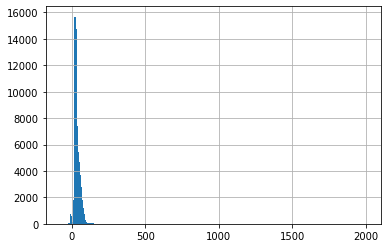

In [314]:
histogram_age = wiki_df['age'].hist(bins=wiki_df['age'].nunique())

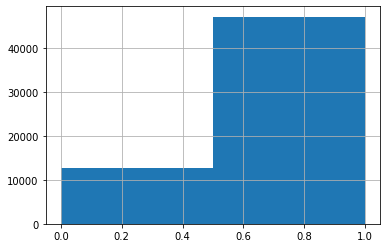

In [315]:
histogram_gender = wiki_df['gender'].hist(bins=wiki_df['gender'].nunique())

### Filter data
1. nastavime kriteria
2. vypocitame pre kazdy riadok
  - face_score nie je -Inf
  - obsahuje iba jednu tvar
  - face confidence je vacsia ako 3
  - pre trenovanie veku
    - vek je medzi 1 az 100
  - pre trenovanie pohlavia
    - pohlavie nie je NaN
3. vymazeme nevhodne riadky

In [316]:
def has_valid_row(row):
    if row['face_score'] == -np.inf:
        return False
    if row['face_score'] < 3:
        return False
    if isinstance(row['second_face_score'], (int, float)) == True and row['second_face_score'] > 0:
        return False
    return True

def has_valid_age(row):
    if has_valid_row(row) == False:
        return False
    if row['age'] <= 0:
        return False
    if row['age'] > 100:
        return False
    
    return True

def has_valid_gender(row):
    if has_valid_row(row) == False:
        return False
    if isinstance(row['gender'], (int, float)) == False:
        return False

    return True

In [317]:
wiki_df['has_valid_age'] = wiki_df.apply(has_valid_age, axis=1)
wiki_df['has_valid_gender'] = wiki_df.apply(has_valid_gender, axis=1)
wiki_df

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,date_of_birth,year_of_birth,age,has_valid_age,has_valid_gender
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,[Sami Jauhojärvi],"[[111.29109473290997, 111.29109473290997, 252....",4.300962,NaN,1981-05-05 00:00:00,1981,28,True,True
1,703186,1964,[48/10000548_1925-04-04_1964.jpg],1.0,[Dettmar Cramer],"[[252.48330229530742, 126.68165114765371, 354....",2.645639,1.949248,1925-04-04 00:00:00,1925,39,False,False
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,[Marc Okrand],"[[113.52, 169.83999999999997, 366.08, 422.4]]",4.329329,NaN,1948-07-03 00:00:00,1948,60,True,True
3,705061,1961,[65/10001965_1930-05-23_1961.jpg],1.0,[Aleksandar Matanović],"[[1, 1, 634, 440]]",-inf,NaN,1930-05-23 00:00:00,1930,31,False,False
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,[Diana Damrau],"[[171.61031405173117, 75.57451239763239, 266.7...",3.408442,NaN,1971-05-31 00:00:00,1971,41,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62323,707582,1963,[49/9996949_1937-04-17_1963.jpg],1.0,[Guus Haak],"[[128.92773553879837, 128.92773553879837, 320....",4.029268,NaN,1937-04-17 00:00:00,1937,26,True,True
62324,711338,1970,[32/9997032_1947-07-30_1970.jpg],1.0,[Nico Rijnders],"[[1, 1, 285, 440]]",-inf,NaN,1947-07-30 00:00:00,1947,23,False,False
62325,720620,2013,[09/9998109_1972-12-27_2013.jpg],1.0,[Michael Wiesinger],"[[169.88839785556354, 74.31669471981023, 235.2...",3.494303,NaN,1972-12-27 00:00:00,1972,41,True,True
62326,723893,2011,[00/9999400_1981-12-13_2011.jpg],1.0,[Johann Grugger],"[[1, 1, 1, 1]]",-inf,NaN,1981-12-13 00:00:00,1981,30,False,False


In [318]:
# Save data set to python format

wiki_df.to_pickle('../data/processed/wiki_meta_df.pkl')

In [319]:
# age_wiki_df will have only rows with True in has_valid_age
age_wiki_df = wiki_df[wiki_df['has_valid_age'] == True]
age_wiki_df.reset_index(drop=True,inplace=True)

# gender_wiki_df will have only rows with True in has_valid_gender
gender_wiki_df = wiki_df[wiki_df['has_valid_gender'] == True]
gender_wiki_df.reset_index(drop=True,inplace=True)

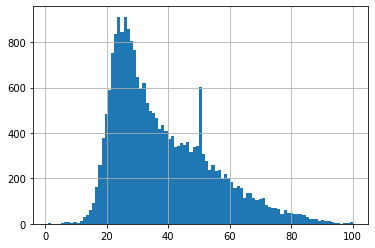

In [320]:
histogram_age = age_wiki_df['age'].hist(bins=age_wiki_df['age'].nunique())

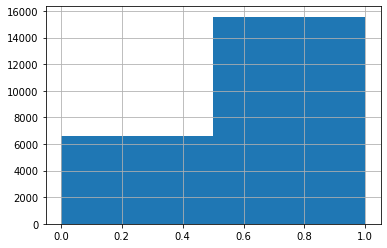

In [321]:
histogram_gender = gender_wiki_df['gender'].hist(bins=gender_wiki_df['gender'].nunique())

In [322]:
age_wiki_df

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,date_of_birth,year_of_birth,age,has_valid_age,has_valid_gender
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,[Sami Jauhojärvi],"[[111.29109473290997, 111.29109473290997, 252....",4.300962,NaN,1981-05-05 00:00:00,1981,28,True,True
1,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,[Marc Okrand],"[[113.52, 169.83999999999997, 366.08, 422.4]]",4.329329,NaN,1948-07-03 00:00:00,1948,60,True,True
2,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,[Diana Damrau],"[[171.61031405173117, 75.57451239763239, 266.7...",3.408442,NaN,1971-05-31 00:00:00,1971,41,True,True
3,716189,2012,[02/10002702_1960-11-09_2012.jpg],0.0,[Krista Tippett],"[[274.76563240288175, 57.7700900839337, 376.88...",4.748056,NaN,1960-11-09 00:00:00,1960,52,True,True
4,707745,1971,[41/10003541_1937-09-27_1971.jpg],1.0,[Bernie Whitebear],"[[79.35580188693945, 26.65993396231315, 197.60...",4.184828,NaN,1937-09-27 00:00:00,1937,34,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22573,707521,1968,[38/9996938_1937-02-15_1968.jpg],1.0,[Coen Moulijn],"[[83.1122019227873, 83.1122019227873, 329.2488...",3.868307,NaN,1937-02-15 00:00:00,1937,31,True,True
22574,709971,1968,[46/9996946_1943-11-01_1968.jpg],1.0,[Theo van Duivenbode],"[[123.45351931209424, 196.99763089935078, 343....",3.735573,NaN,1943-11-01 00:00:00,1943,25,True,True
22575,707582,1963,[49/9996949_1937-04-17_1963.jpg],1.0,[Guus Haak],"[[128.92773553879837, 128.92773553879837, 320....",4.029268,NaN,1937-04-17 00:00:00,1937,26,True,True
22576,720620,2013,[09/9998109_1972-12-27_2013.jpg],1.0,[Michael Wiesinger],"[[169.88839785556354, 74.31669471981023, 235.2...",3.494303,NaN,1972-12-27 00:00:00,1972,41,True,True


In [323]:
gender_wiki_df

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,date_of_birth,year_of_birth,age,has_valid_age,has_valid_gender
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,[Sami Jauhojärvi],"[[111.29109473290997, 111.29109473290997, 252....",4.300962,NaN,1981-05-05 00:00:00,1981,28,True,True
1,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,[Marc Okrand],"[[113.52, 169.83999999999997, 366.08, 422.4]]",4.329329,NaN,1948-07-03 00:00:00,1948,60,True,True
2,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,[Diana Damrau],"[[171.61031405173117, 75.57451239763239, 266.7...",3.408442,NaN,1971-05-31 00:00:00,1971,41,True,True
3,716189,2012,[02/10002702_1960-11-09_2012.jpg],0.0,[Krista Tippett],"[[274.76563240288175, 57.7700900839337, 376.88...",4.748056,NaN,1960-11-09 00:00:00,1960,52,True,True
4,707745,1971,[41/10003541_1937-09-27_1971.jpg],1.0,[Bernie Whitebear],"[[79.35580188693945, 26.65993396231315, 197.60...",4.184828,NaN,1937-09-27 00:00:00,1937,34,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22591,707521,1968,[38/9996938_1937-02-15_1968.jpg],1.0,[Coen Moulijn],"[[83.1122019227873, 83.1122019227873, 329.2488...",3.868307,NaN,1937-02-15 00:00:00,1937,31,True,True
22592,709971,1968,[46/9996946_1943-11-01_1968.jpg],1.0,[Theo van Duivenbode],"[[123.45351931209424, 196.99763089935078, 343....",3.735573,NaN,1943-11-01 00:00:00,1943,25,True,True
22593,707582,1963,[49/9996949_1937-04-17_1963.jpg],1.0,[Guus Haak],"[[128.92773553879837, 128.92773553879837, 320....",4.029268,NaN,1937-04-17 00:00:00,1937,26,True,True
22594,720620,2013,[09/9998109_1972-12-27_2013.jpg],1.0,[Michael Wiesinger],"[[169.88839785556354, 74.31669471981023, 235.2...",3.494303,NaN,1972-12-27 00:00:00,1972,41,True,True


### Prepare images for NN



Populating the interactive namespace from numpy and matplotlib


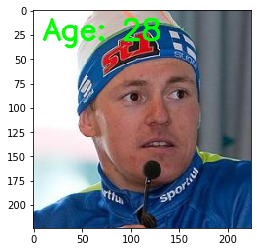

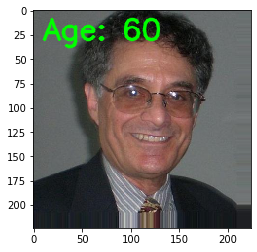

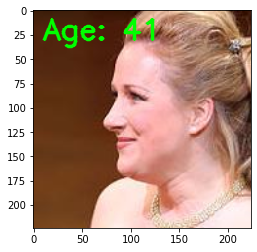

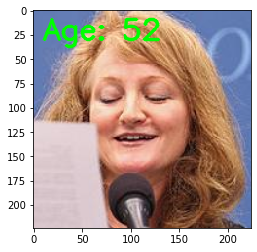

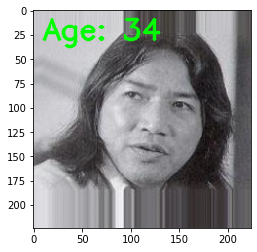

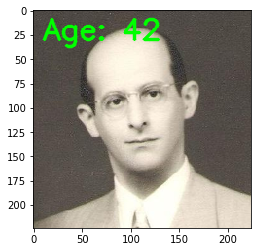

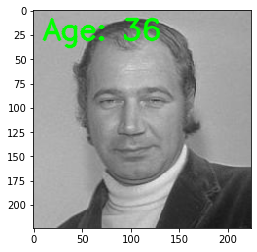

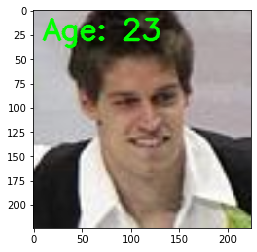

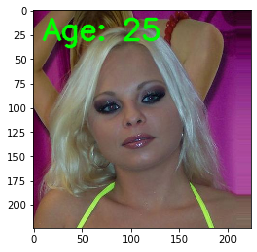

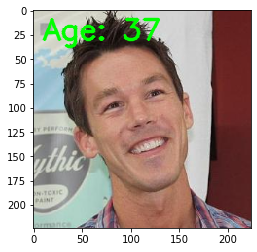

In [324]:
%pylab inline

font = cv2.FONT_HERSHEY_SIMPLEX

for i in range(10):
    age = 'Age: ' + str(age_wiki_df['age'][int(i)])
    image_path = '../data/raw/wiki_crop/' + str(age_wiki_df['full_path'][int(i)][0])

    im = cv2.imread(image_path)
    im_resized = cv2.resize(im, (224, 224), interpolation=cv2.INTER_LINEAR)

    cv2.putText(im_resized, age, (10,30), font, 1, (0, 255, 0), 2, cv2.LINE_AA)

    plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
    plt.show()

    # load file
    # show plot
    # print age
    # resize to 224x224x3 (https://github.com/matus-pikuliak/neural_networks_at_fiit/blob/92b24eef8e6444c43a22e8fa51a349b3b1043a7c/week_7/week_7.ipynb)


**TODOS:**

### Expand data set
- opencv rotation
- opencv scale
- opencv blur, noise, ...

## Load data for traing
- ???

## Imdb dataset analysis

- **TODO:** Same action as with wiki datasets

In [325]:
print("keys:", imdb_mat.keys()) # keys: dict_keys(['__header__', '__version__', '__globals__', 'imdb'])

imdb = imdb_mat['imdb']

print("dtype:", (imdb[0][0]).dtype)

print("L1:", len(imdb))
print("L2:", len(imdb[0]))
print("L3:", len(imdb[0][0]))
print("L4:", len(imdb[0][0][0]))
print("L5:", len(imdb[0][0][0][0]))
print("L6 (data):", imdb[0][0][0][0][0])

keys: dict_keys(['__header__', '__version__', '__globals__', 'imdb'])
dtype: [('dob', 'O'), ('photo_taken', 'O'), ('full_path', 'O'), ('gender', 'O'), ('name', 'O'), ('face_location', 'O'), ('face_score', 'O'), ('second_face_score', 'O'), ('celeb_names', 'O'), ('celeb_id', 'O')]
L1: 1
L2: 1
L3: 10
L4: 1
L5: 460723
L6 (data): 693726


In [326]:
for j in range(columns_n):
    print(len(imdb[0][0][j][0]))

460723
460723
460723
460723
460723
460723
460723
460723


In [327]:
#for x in range(20284, 460724):
#    imdb[0][0][8][0][x] = None
#
#print(len(imdb[0][0][8][0]))

In [328]:
# Transform to df

columns_n = len(imdb[0][0]) # 10
rows_n = len(imdb[0][0][0][0]) # 460723
columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score", "celeb_names", "celeb_id"]

imdb_df = None

for i in range(1):
    data = {}
    for j in range(columns_n):
        column = imdb[0][0][j][0]
        data[columns[j]] = column
        if j == 8:
            n = np.zeros(440439)
            data[columns[j]] = np.concatenate((column, n))
            continue # skip 8th column. 

    imdb_df = pd.DataFrame(data = data, columns = columns)

#column8 = imdb[0][0][8][0]
#df2 = pd.DataFrame(index = range(rows_n), columns = ['celeb_names'])
#for x in range(len(imdb[0][0][8][0])):
    #df2['celeb_names'][x] = pd.DataFrame(imdb[0][0][8][0][x])
    #imdb_df['celeb_names'][x] = str(imdb[0][0][8][0][x][0])

#df3 = pd.DataFrame(data = column8, columns = ['celeb_names'])
#df2.append(df3, ignore_index = True)
#imdb_df.append(df2)

In [329]:
imdb_df['date_of_birth'] = [matlab2datetime(datenum) for datenum in imdb_df['dob']] # For invalid dt None is returned
imdb_df['year_of_birth'] = [dt.year for dt in imdb_df['date_of_birth']]
imdb_df['age'] = imdb_df['photo_taken'] - imdb_df['year_of_birth']

In [330]:

# Identifies invalid values - about 129 rows
imdb_df[ imdb_df['date_of_birth'].isna() ]


,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,celeb_names,celeb_id,date_of_birth,year_of_birth,age
139296,357,2013,[24/nm0004624_rm1394516224_0-12-22_2013.jpg],1.0,[Eddie Mui],"[[417.4020088088457, 698.6033661121198, 517.41...",2.089765,1.052731,0,5539,NaT,NaN,NaN
157487,142,2000,[54/nm0005054_rm978880768_0-5-21_2000.jpg],0.0,[Gladise Jiminez],"[[1, 1, 280, 373]]",-inf,NaN,0,6978,NaT,NaN,NaN
178453,323,2006,[55/nm0005555_rm2332859648_0-11-18_2006.jpg],0.0,[Anna Wilding],"[[176.38243837978087, 62.17325343292329, 254.7...",3.347509,NaN,0,1197,NaT,NaN,NaN
178454,323,2005,[55/nm0005555_rm2469698304_0-11-18_2005.jpg],0.0,[Anna Wilding],"[[130.39282344264836, 108.80901953554029, 323....",2.733648,NaN,0,1197,NaT,NaN,NaN
178455,323,2006,[55/nm0005555_rm2702875904_0-11-18_2006.jpg],0.0,[Anna Wilding],"[[100.14753787174381, 166.312563119573, 396.99...",4.513977,NaN,0,1197,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
455691,209,2006,[14/nm0790814_rm1051171584_0-7-27_2006.jpg],0.0,[Tamie Sheffield],"[[95.4664857262113, 57.48869143572678, 151.911...",3.755334,NaN,0,18546,NaT,NaN,NaN
455692,209,2006,[14/nm0790814_rm1067948800_0-7-27_2006.jpg],0.0,[Tamie Sheffield],"[[149.80345948665433, 75.17372974332717, 233.2...",5.499919,3.607659,0,18546,NaT,NaN,NaN
455693,209,2004,[14/nm0790814_rm24418816_0-7-27_2004.jpg],0.0,[Tamie Sheffield],"[[114.576, 30.096, 152.064, 67.584]]",2.823674,NaN,0,18546,NaT,NaN,NaN
455694,209,2004,[14/nm0790814_rm7641600_0-7-27_2004.jpg],0.0,[Tamie Sheffield],"[[100.50503020410876, 100.50503020410876, 249....",4.523486,NaN,0,18546,NaT,NaN,NaN


In [331]:
imdb_df

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,celeb_names,celeb_id,date_of_birth,year_of_birth,age
0,693726,1968,[01/nm0000001_rm124825600_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[1072.926, 161.838, 1214.7839999999999, 303.6...",1.459693,1.118973,['Lee' George Quinones],6488,1899-05-10,1899.0,69.0
1,693726,1970,[01/nm0000001_rm3343756032_1899-5-10_1970.jpg],1.0,[Fred Astaire],"[[477.184, 100.352, 622.592, 245.76]]",2.543198,1.852008,['Weird Al' Yankovic],6488,1899-05-10,1899.0,71.0
2,693726,1968,[01/nm0000001_rm577153792_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[114.96964308962852, 114.96964308962852, 451....",3.455579,2.985660,[2 Chainz],6488,1899-05-10,1899.0,69.0
3,693726,1968,[01/nm0000001_rm946909184_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[622.8855056426588, 424.21750383700805, 844.3...",1.872117,NaN,[50 Cent],6488,1899-05-10,1899.0,69.0
4,693726,1968,[01/nm0000001_rm980463616_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[1013.8590023603723, 233.8820422075853, 1201....",1.158766,NaN,[A Martinez],6488,1899-05-10,1899.0,69.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
460718,726831,2011,[08/nm3994408_rm761245696_1989-12-29_2011.jpg],0.0,[Jane Levy],"[[453.8981431333457, 77.96623712908011, 539.79...",3.845884,NaN,0,8410,1989-12-29,1989.0,22.0
460719,726831,2011,[08/nm3994408_rm784182528_1989-12-29_2011.jpg],0.0,[Jane Levy],"[[1, 1, 426, 640]]",-inf,NaN,0,8410,1989-12-29,1989.0,22.0
460720,726831,2011,[08/nm3994408_rm926592512_1989-12-29_2011.jpg],0.0,[Jane Levy],"[[1, 1, 453, 640]]",-inf,NaN,0,8410,1989-12-29,1989.0,22.0
460721,726831,2011,[08/nm3994408_rm943369728_1989-12-29_2011.jpg],0.0,[Jane Levy],"[[144.75225471724875, 126.76472287759263, 305....",4.450725,NaN,0,8410,1989-12-29,1989.0,22.0


In [332]:
imdb_df.describe()

,dob,photo_taken,gender,face_score,second_face_score,celeb_id,year_of_birth,age
count,460723.000000,460723.000000,452261.000000,4.607230e+05,213797.000000,460723.000000,460594.000000,460594.000000
mean,718987.731774,2005.461555,0.581996,-inf,2.452904,10116.802404,1968.559488,36.901406
std,13253.963535,9.054475,0.493231,NaN,1.064432,5742.153266,15.242675,13.208932
min,47.000000,1961.000000,0.000000,-inf,0.730926,1.000000,1732.000000,-30.000000
25%,716370.000000,2004.000000,0.000000,1.757891e+00,1.583692,5294.000000,1961.000000,28.000000
50%,719935.000000,2008.000000,1.000000,2.980097e+00,2.355163,10066.000000,1971.000000,35.000000
75%,723073.000000,2011.000000,1.000000,4.006376e+00,3.228071,14922.000000,1979.000000,44.000000
max,734963.000000,2015.000000,1.000000,7.381689e+00,6.395435,20284.000000,2012.000000,282.000000


In [333]:
imdb_df.to_pickle('../data/processed/imdb_meta_df.pkl')

TODO
- otvorit meta data
- konvertovat do py
- ...